#### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [18]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
import PIL
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Data Reading/Data Understanding

In [19]:
#reading the dataset
data_dir_train = pathlib.Path("D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path("D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [20]:
data_dir_train

WindowsPath('D:/Roshni/Post Graduation/CASE STUDIES/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

### Dataset Creation

In [21]:
#count of images in train and test test
train_images_count = len(list(data_dir_train.glob('*/*.jpg')))
test_images_count = len(list(data_dir_test.glob('*/*.jpg')))
print(train_images_count)
print(test_images_count)

2239
118


In [22]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                                    label_mode='categorical',
                                                                    seed=123,image_size=(180,180))

Found 2239 files belonging to 9 classes.


In [23]:
image_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [24]:
class_names = image_dataset.class_names

### Dataset visualisation 

In [57]:

files_path_dict = {}
for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x, os.listdir(str(data_dir_train)+'/'+c)))

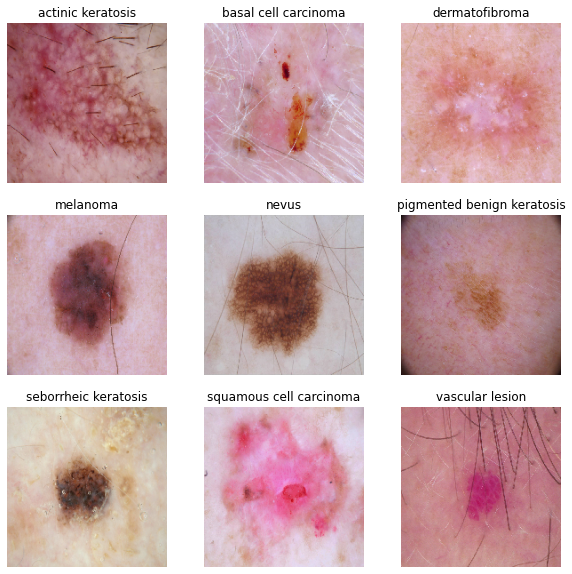

In [26]:
# viewing images from different classes

from tensorflow.keras.preprocessing.image import load_img
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0], target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [27]:
#Checking for number of images in each class
def class_distribution_count(directory):
    count = []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                             if os.path.isfile(os.path.join(path, name))]))
    
    sub_directories = [name for name in os.listdir(directory)
                      if os.path.isdir(os.path.join(directory, name))]
    
    return pd.DataFrame(list(zip(sub_directories, count)), columns=["Class", "No of Images"])


df = class_distribution_count(data_dir_train)
df

,Class,No of Images
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


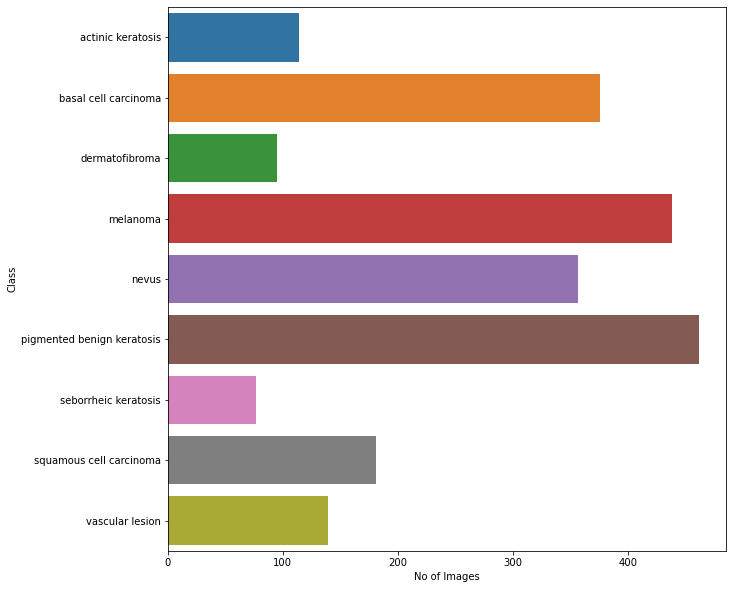

In [28]:
#visualising the classes and the number of images present in each classs
plt.figure(figsize=(10,10))
sns.barplot(x="No of Images", y= "Class", data=df)
plt.show()

- We see that seborrheic keratosis data has very less samples, where as pigmented benign keratosis has more number of samples

- From the above bar plot, it is obeserved that there is a class imbalance 

In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [30]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### First Model Building & training

In [31]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

In [32]:
model.compile(optimizer = 'Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [34]:
#train the model
epochs = 20
history = model.fit(train_ds, validation_data = val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 76s 1s/step - loss: 2.0113 - accuracy: 0.2729 - val_loss: 1.6402 - val_accuracy: 0.4116
Epoch 2/20
56/56 [==============================] - 76s 1s/step - loss: 1.5921 - accuracy: 0.4347 - val_loss: 1.4638 - val_accuracy: 0.5056
Epoch 3/20
56/56 [==============================] - 79s 1s/step - loss: 1.4716 - accuracy: 0.4810 - val_loss: 1.4664 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 75s 1s/step - loss: 1.3641 - accuracy: 0.5140 - val_loss: 1.3564 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 71s 1s/step - loss: 1.2877 - accuracy: 0.5497 - val_loss: 1.4057 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 68s 1s/step - loss: 1.2470 - accuracy: 0.5491 - val_loss: 1.3591 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 66s 1s/step - loss: 1.1509 - accuracy: 0.5848 - val_loss: 1.3859 - val_accuracy: 0.5235
Epoch 8/20
56/56 [==

- With the train and validation accuracy, it is observed that the train accuracy is more while the validation accuracy is very less.This model is definetly overfitting
- This overfitting might be because of class imbalance

#### Data augmentation strategy

- As we saw overfitting problem, in the next steps Im trying to implement data augmentation strategy to solve the class imbalance

In [35]:
# importing Augmentor

!pip install Augmentor
import Augmentor

In [36]:
path_to_training_dataset = "D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/"
#As there is class imbalance, using Augmentation to balance all the classes
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D30E1F2E80>: 100%|█| 500/500 [00:07<00:00, 67.12 Samples/


Initialised with 376 image(s) found.
Output directory set to D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D313749400>: 100%|█| 500/500 [00:07<00:00, 68.75 Samples/


Initialised with 95 image(s) found.
Output directory set to D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D30E1F76D0>: 100%|█| 500/500 [00:06<00:00, 79.15 Samples/


Initialised with 438 image(s) found.
Output directory set to D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1D3029BDAF0>: 100%|█| 500/500 [00:31<00:00, 16.06 Samples


Initialised with 357 image(s) found.
Output directory set to D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1D30224E400>: 100%|█| 500/500 [00:28<00:00, 17.25 Samples


Initialised with 462 image(s) found.
Output directory set to D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D30269E640>: 100%|█| 500/500 [00:06<00:00, 74.51 Samples/


Initialised with 77 image(s) found.
Output directory set to D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1D3025C7DC0>: 100%|█| 500/500 [00:16<00:00, 29.81 Samples


Initialised with 181 image(s) found.
Output directory set to D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D302504820>: 100%|█| 500/500 [00:06<00:00, 72.16 Samples/


Initialised with 139 image(s) found.
Output directory set to D:\Roshni\Post Graduation\CASE STUDIES\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D37F585220>: 100%|█| 500/500 [00:06<00:00, 82.14 Samples/


In [37]:
#Count total number of image generated by Augmentor.

image_count = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count)

4500


In [38]:
# train dataset 
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [40]:
# validation dataset 
val_ds_aug =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

### Second Model Building & training on the augmented data

In [42]:
# Building another model 
model1 = Sequential()
model1.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))

#First Convulation layer
model1.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model1.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model1.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))



#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model1.add(layers.Flatten())

#Dense Layer
model1.add(layers.Dense(128,activation='relu'))



#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model1.add(layers.Dense(len(class_names),activation='softmax'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

In [43]:
#compiling the model
model1.compile(optimizer = 'Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
checkpoint = ModelCheckpoint("model1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#### Training the Model

In [45]:

epochs = 20
history2 = model1.fit(train_ds_aug, validation_data = val_ds_aug, epochs=epochs, callbacks=[checkpoint, earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.9556 - accuracy: 0.2630
Epoch 1: val_accuracy improved from -inf to 0.38456, saving model to model1.h5
169/169 [==============================] - 216s 1s/step - loss: 1.9556 - accuracy: 0.2630 - val_loss: 1.5770 - val_accuracy: 0.3846
Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.5221 - accuracy: 0.4167
Epoch 2: val_accuracy improved from 0.38456 to 0.45805, saving model to model1.h5
169/169 [==============================] - 153s 904ms/step - loss: 1.5221 - accuracy: 0.4167 - val_loss: 1.4002 - val_accuracy: 0.4581
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3413 - accuracy: 0.4939
Epoch 3: val_accuracy improved from 0.45805 to 0.50260, saving model to model1.h5
169/169 [==============================] - 156s 922ms/step - loss: 1.3413 - accuracy: 0.4939 - val_loss: 1.3212 - val_accuracy: 0.5026
Epoch 4/20
169/169 [==============================] - ETA: 0s - los

### Trying another CNN model-3 using drop outs to see if the validation accuracy score increases with dropouts

In [46]:
model2 = Sequential()
model2.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))

#First Convulation layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 128)      

In [47]:
#compiling the model
model2.compile(optimizer = 'Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model 
# or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [49]:
#train the model
epochs = 30
history3 = model2.fit(train_ds_aug, validation_data = val_ds_aug, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 143s 831ms/step - loss: 1.9164 - accuracy: 0.2634 - val_loss: 1.5750 - val_accuracy: 0.3846
Epoch 2/30
169/169 [==============================] - 134s 794ms/step - loss: 1.5735 - accuracy: 0.3958 - val_loss: 1.5143 - val_accuracy: 0.4336
Epoch 3/30
169/169 [==============================] - 142s 841ms/step - loss: 1.4416 - accuracy: 0.4518 - val_loss: 1.3377 - val_accuracy: 0.4907
Epoch 4/30
169/169 [==============================] - 135s 801ms/step - loss: 1.3567 - accuracy: 0.4911 - val_loss: 1.3084 - val_accuracy: 0.5152
Epoch 5/30
169/169 [==============================] - 136s 806ms/step - loss: 1.2705 - accuracy: 0.5197 - val_loss: 1.2426 - val_accuracy: 0.5323
Epoch 6/30
169/169 [==============================] - 136s 806ms/step - loss: 1.2199 - accuracy: 0.5352 - val_loss: 1.3386 - val_accuracy: 0.5197
Epoch 7/30
169/169 [==============================] - 146s 863ms/step - loss: 1.1541 - accuracy: 0.5625 - val_loss: 1.1980 -

- We can see that there is definetly increase in the validation score when we use the dropouts in the CNN architecture

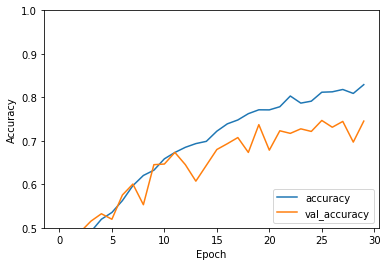

In [55]:
# Plotting training accuracy and validation accuracy
plt.plot(history3.history['accuracy'],label='accuracy')
plt.plot(history3.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()